### **Imports**

In [247]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC, SVR
from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from pickle import dump, load

#### Model Selection

In [248]:
lr = LogisticRegression()
gb = GradientBoostingClassifier(n_estimators=20, random_state = 42)
xg = XGBClassifier()
bernoulli = BernoulliNB()
svm = SVC()
knn = KNeighborsClassifier(n_neighbors=2)

models = [lr, gb, xg, bernoulli, svm, knn]

#### Loading and exploring the data

In [249]:
#url: https://archive.ics.uci.edu/dataset/331/sentiment+labelled+sentences
amazon = pd.read_csv('sentiment labelled sentences/amazon_cells_labelled.txt', sep='\t', header=None, names=['sentence', 'score'])
imdb = pd.read_csv('sentiment labelled sentences/imdb_labelled.txt', sep='\t', header=None, names=['sentence', 'score'])
yelp = pd.read_csv('sentiment labelled sentences/yelp_labelled.txt', sep='\t', header=None, names=['sentence', 'score'])

In [250]:
amazon.head()

,sentence,score
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [251]:
imdb.head()

,sentence,score
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


In [252]:
yelp.head()

,sentence,score
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [253]:
print(amazon.info())
print(imdb.info())
print(yelp.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  1000 non-null   object
 1   score     1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  748 non-null    object
 1   score     748 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 11.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  1000 non-null   object
 1   score     1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB
None


In [254]:
df = pd.concat([amazon, imdb, yelp], axis=0)
df.head()

,sentence,score
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [255]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2748 entries, 0 to 999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  2748 non-null   object
 1   score     2748 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 64.4+ KB


#### Data Cleaning

In [256]:
#Checking for null values
df.isnull().sum()

sentence    0
score       0
dtype: int64

In [257]:
#Checking for duplicated
df.duplicated().sum()

17

In [258]:
df = df.drop_duplicates()

In [259]:
df = df.reset_index(inplace=False, drop=True)
df.shape

(2731, 2)

In [260]:
df.to_csv('sentiment_analysis.csv', index=False)

#### EDA

In [261]:
df.score.value_counts()

score
1    1376
0    1355
Name: count, dtype: int64

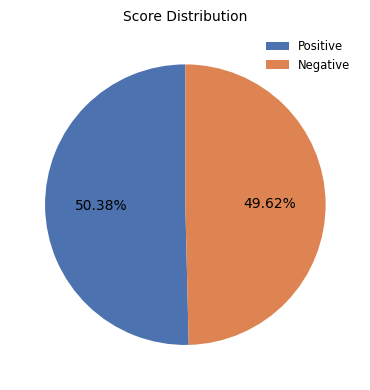

In [262]:
legend=['Positive', 'Negative']
colours = sns.color_palette('deep')
fig = plt.figure(figsize=(6,4))
df.score.value_counts().plot(kind='pie', autopct='%1.2f%%', startangle=90, colors=colours, labels=None)
plt.ylabel('')
plt.title('Score Distribution', fontsize='medium')
plt.legend(legend, frameon=False, fontsize='small', loc='best')
plt.tight_layout()
plt.show()

#### Preparing the data

In [263]:
#Processing test
df['sentence'] = df['sentence'].str.strip().str.lower().replace('\t', ' ').replace('\n', ' ').replace('.', '')

In [264]:
df.head()

,sentence,score
0,so there is no way for me to plug it in here i...,0
1,"good case, excellent value.",1
2,great for the jawbone.,1
3,tied to charger for conversations lasting more...,0
4,the mic is great.,1


#### Data split

In [265]:
X = df.drop('score', axis=1)
y = df['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [266]:
print('Train data:', X_train.shape, y_train.shape)
print('Test data:', X_test.shape, y_test.shape)

Train data: (2184, 1) (2184,)
Test data: (547, 1) (547,)


#### Transforming data into array

In [267]:
vector = TfidfVectorizer()

X_train = vector.fit_transform(X_train['sentence']).toarray()
X_test = vector.transform(X_test['sentence']).toarray()

In [268]:
#Saving the vector
dump(vector, open("vector_tfidf.sav", "wb"))

### **Training the models**

In [269]:
models_dict = []

for model in models:
    print(f'Fitting {model.__class__.__name__}...')
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    acc_train = accuracy_score(y_train, y_train_pred)
    acc_test = accuracy_score(y_test, y_test_pred)
    print(f'Accuracy Score on train data is {acc_train:.2f}')
    print(f'Accuracy Score on test data is {acc_test:.2f}\n')

    models_dict.append({'model': model.__class__.__name__, 'acc_train': acc_train, 'acc_test': acc_test})

Fitting LogisticRegression...
Accuracy Score on train data is 0.95
Accuracy Score on test data is 0.80

Fitting GradientBoostingClassifier...
Accuracy Score on train data is 0.71
Accuracy Score on test data is 0.70

Fitting XGBClassifier...
Accuracy Score on train data is 0.93
Accuracy Score on test data is 0.77

Fitting BernoulliNB...
Accuracy Score on train data is 0.95
Accuracy Score on test data is 0.79

Fitting SVC...
Accuracy Score on train data is 0.99
Accuracy Score on test data is 0.80

Fitting KNeighborsClassifier...
Accuracy Score on train data is 0.89
Accuracy Score on test data is 0.73



In [270]:
acc_df = pd.DataFrame(models_dict)
acc_df

,model,acc_train,acc_test
0,LogisticRegression,0.946886,0.797075
1,GradientBoostingClassifier,0.713828,0.702011
2,XGBClassifier,0.934066,0.773309
3,BernoulliNB,0.945971,0.787934
4,SVC,0.993590,0.802559
5,KNeighborsClassifier,0.889652,0.725777


#### Optimizing the best model

##### RandomizedSearch

In [271]:
hyperparams = {
    'n_estimators': [20,50,100,200],
    "max_depth": [1,2,3,4,5],
    'learning_rate': [0.00001, 0.0001, 0.001,0.01, 0.1]
    }
op = RandomizedSearchCV(estimator=xg, param_distributions=hyperparams, n_iter=8, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)
op

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=8, n_jobs=-1,
                   param_distributions={'learning_rate': [1e-05, 0.0001, 0.001,
                                                          0.01, 0.1],
                                        'max_depth': [1, 2, 3, 4, 5],
                                        'n_estimators': [20, 50, 100, 200]},
                   random_state=42, scoring='accuracy')

In [275]:
#Bernoulli
hyperparams = {
    'force_alpha': [True, False],
    'alpha': [0, 1.0, 2.0],
    'fit_prior': [True, False],
    #'binarize': [None, 2.0, 5.0]
    }
op = RandomizedSearchCV(estimator=bernoulli, param_distributions=hyperparams, n_iter=8, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)
op

RandomizedSearchCV(cv=5, estimator=BernoulliNB(), n_iter=8, n_jobs=-1,
                   param_distributions={'alpha': [0, 1.0, 2.0],
                                        'fit_prior': [True, False],
                                        'force_alpha': [True, False]},
                   random_state=42, scoring='accuracy')

In [276]:
op.fit(X_train, y_train)
print("Best Hyperparameters:", op.best_params_)
op_best = op.best_estimator_

Best Hyperparameters: {'force_alpha': False, 'fit_prior': True, 'alpha': 1.0}


In [277]:
op_best.fit(X_train, y_train)
y_pred_train = op_best.predict(X_train)
y_pred_test = op_best.predict(X_test)

In [278]:
acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_test_pred)
print(f'Accuracy on train data: {acc_train:.2f}')
print(f'Accuracy on test data:  {acc_test:.2f}')

Accuracy on train data: 0.89
Accuracy on test data:  0.73


##### GridSearch

In [182]:
grid_op = GridSearchCV(estimator=xg, param_grid=hyperparams, scoring='accuracy', n_jobs=-1, cv=5)
grid_op

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [1e-05, 0.0001, 0.001, 0.01, 0.1],
                         'max_depth': [1, 2, 3, 4, 5],
                         'n_estimators': [20, 50, 100, 200]},
             scoring='accuracy')

In [183]:
grid_op.fit(X_train, y_train)
print("Best Hyperparameters:", grid_op.best_params_)
grid_op = op.best_estimator_

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}


In [184]:
grid_op.fit(X_train, y_train)
y_pred_train = grid_op.predict(X_train)
y_pred_test = grid_op.predict(X_test)

In [185]:
acc_train_grid = accuracy_score(y_train, y_train_pred)
acc_test_grid = accuracy_score(y_test, y_test_pred)
print(f'Accuracy on train data: {acc_train_grid:.2f}')
print(f'Accuracy on test data:  {acc_test_grid:.2f}')

Accuracy on train data: 0.89
Accuracy on test data:  0.73


#### Saving the model

In [186]:
dump(svm, open("xg_sentiment_analysis.sav", "wb"))

In [187]:
model = load(open("xg_sentiment_analysis.sav", "rb"))

In [188]:
y = list(model.predict(X_test))

In [189]:
y[2]

0

In [190]:
from collections import Counter
# Use Counter to count unique values
counts = Counter(y)

for value, count in counts.items():
    if value == 1:
        print(f'Positive: {count}')
    else:
        print(f'Negative: {count}')

Positive: 273
Negative: 274


In [244]:
sentence = "Oh, great! Another meeting. Just what I needed to make my day amazing."

In [195]:
test = [sentence.strip().lower().replace('\t', ' ').replace('\n', ' ').replace('.', '')]
test = vector.transform(test).toarray()

In [196]:
x = model.predict(test)
x

array([1], dtype=int64)

In [245]:
def predict_sentiment(str):
    sentence = [str.strip().lower().replace('\t', ' ').replace('\n', ' ').replace('.', '')]
    sentence_vector = vector.transform(sentence).toarray()
    prediction = model.predict(sentence_vector)
    if prediction == 1:
        return 'Positive'
    else:
        return 'Negative'

In [246]:
predict_sentiment(sentence)

1/1 [==============================] - 0s 50ms/step


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [280]:
import keras
import tensorflow as tf
from keras import layers
from tensorflow import data as tf_data
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Embedding, GlobalMaxPooling1D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from tensorflow.keras.utils import to_categorical

In [238]:
model = Sequential()
model.add(Embedding(input_dim=4591, output_dim=32, input_length=4591))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 4591, 32)          146912    
                                                                 
 conv1d_10 (Conv1D)          (None, 4589, 64)          6208      
                                                                 
 global_max_pooling1d_9 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_24 (Dense)            (None, 64)                4160      
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_25 (Dense)            (None, 2)                 130       
                                                     

In [239]:
y_train_cat = to_categorical(y_train, num_classes=2)
y_test_cat = to_categorical(y_test, num_classes=2)

In [240]:
model.fit(X_train, y_train_cat, epochs=10, batch_size=64, validation_split=0.2, verbose=1)

Epoch 1/10
28/28 [==============================] - 10s 335ms/step - loss: 0.6923 - accuracy: 0.5215 - val_loss: 0.6939 - val_accuracy: 0.4828
Epoch 2/10
28/28 [==============================] - 9s 322ms/step - loss: 0.6938 - accuracy: 0.5089 - val_loss: 0.6950 - val_accuracy: 0.4828
Epoch 3/10
28/28 [==============================] - 9s 324ms/step - loss: 0.6934 - accuracy: 0.5037 - val_loss: 0.6938 - val_accuracy: 0.4828
Epoch 4/10
28/28 [==============================] - 9s 325ms/step - loss: 0.6939 - accuracy: 0.5106 - val_loss: 0.6935 - val_accuracy: 0.4828
Epoch 5/10
28/28 [==============================] - 9s 328ms/step - loss: 0.6921 - accuracy: 0.5295 - val_loss: 0.6936 - val_accuracy: 0.4828
Epoch 6/10
28/28 [==============================] - 10s 339ms/step - loss: 0.6940 - accuracy: 0.4940 - val_loss: 0.6936 - val_accuracy: 0.4828
Epoch 7/10
28/28 [==============================] - 9s 327ms/step - loss: 0.6927 - accuracy: 0.5089 - val_loss: 0.6939 - val_accuracy: 0.4828
Epoc

In [213]:
X_train.reshape(2184, 4591)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])